In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, classification_report, accuracy_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import ipaddress
from sklearn.ensemble import RandomForestClassifier
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import time
from sklearn.utils import class_weight

In [2]:
import ipaddress
import pandas as pd
import numpy as np
import os

# IP 주소를 정수로 변환하는 함수
def convert_ip2int(ip):
    try:
        return int(ipaddress.ip_address(ip))
    except ValueError:
        return 0

# 데이터 로딩, 전처리 및 시계열 데이터 생성을 위한 통합 함수
def load_preprocess_and_sequence_data(file_paths, data_path='dataset/', time_window='1T', time_steps=10):
    df_list = []
    for file_name in file_paths:
        file_path = os.path.join(data_path, file_name)
        df = pd.read_csv(file_path, encoding='latin1', low_memory=False, on_bad_lines='skip')
        df.columns = df.columns.str.strip()
        df_list.append(df)

    full_df = pd.concat(df_list, ignore_index=True)

    # 2. 전처리
    full_df.columns = full_df.columns.str.replace('[ /]', '_', regex=True)
    full_df.replace([np.inf, -np.inf], np.nan, inplace=True)

        
    full_df.dropna(subset=['Timestamp'], inplace=True)
    full_df['Timestamp'] = pd.to_datetime(full_df['Timestamp'], errors='coerce')
    full_df.dropna(subset=['Timestamp'], inplace=True)

    full_df['Source_IP'] = full_df['Source_IP'].astype(str).apply(convert_ip2int)
    full_df['Destination_IP'] = full_df['Destination_IP'].astype(str).apply(convert_ip2int)

    full_df.drop(columns=['Flow_ID'], inplace=True)

    full_df.fillna(0, inplace=True)

    full_df.set_index('Timestamp', inplace=True)
        
    full_df['Label'] = np.where(full_df['Label'] == 'BENIGN', 0, 1)

    # 3. 데이터 집계
    numeric_cols = full_df.select_dtypes(include=np.number).columns.tolist()
    agg_funcs = {col: 'mean' for col in numeric_cols if col not in ['Label']}
    agg_funcs.update({'Label': 'max'})
    
    special_aggs = {
        'Total_Fwd_Packets': 'sum', 'Total_Backward_Packets': 'sum',
        'Total_Length_of_Fwd_Packets': 'sum', 'Source_IP': 'nunique', 'Destination_IP': 'nunique'
    }
    for col, func in special_aggs.items():
        if col in full_df.columns:
            agg_funcs[col] = func

    agg_funcs = {k: v for k, v in agg_funcs.items() if k in full_df.columns}

    df_agg = full_df.resample(time_window).agg(agg_funcs)
    df_agg.fillna(0, inplace=True)

    # 4. 시퀀스 생성
    X_agg = df_agg.drop('Label', axis=1).values
    y_agg = df_agg['Label'].values

    X_seq, y_seq = [], []
    if len(X_agg) > time_steps:
        for i in range(len(X_agg) - time_steps):
            X_seq.append(X_agg[i:(i + time_steps)])
            y_seq.append(y_agg[i + time_steps - 1])
    
    return np.array(X_seq), np.array(y_seq)

In [3]:
# 하이퍼파라미터
TIME_STEPS = 10
TIME_WINDOW = '1T'

# 1. 데이터 파일 분리
data_path = 'dataset/'
all_files = [f for f in os.listdir(data_path) if f.endswith('.csv')]
train_files = [f for f in all_files if 'Wednesday' not in f]
test_files = [f for f in all_files if 'Wednesday' in f]

print("학습용 파일:", train_files)
print("테스트용 파일:", test_files)
print("-" * 50)

# 2. 데이터 로드 및 시퀀스 생성
X_train_seq, y_train_seq = load_preprocess_and_sequence_data(train_files, data_path=data_path, time_window=TIME_WINDOW, time_steps=TIME_STEPS)
X_test_seq, y_test_seq = load_preprocess_and_sequence_data(test_files, data_path=data_path, time_window=TIME_WINDOW, time_steps=TIME_STEPS)

print(f"원본 학습 데이터 형태: {X_train_seq.shape}, {y_train_seq.shape}")
print(f"원본 테스트 데이터 형태: {X_test_seq.shape}, {y_test_seq.shape}")
print("-" * 50)

# 3. 데이터 스케일링
nsamples, nsteps, nfeatures = X_train_seq.shape
X_train_2d = X_train_seq.reshape((nsamples * nsteps, nfeatures))

scaler = StandardScaler()
X_train_scaled_2d = scaler.fit_transform(X_train_2d)
X_train_scaled_seq = X_train_scaled_2d.reshape((nsamples, nsteps, nfeatures))

nsamples_test, nsteps_test, nfeatures_test = X_test_seq.shape
X_test_2d = X_test_seq.reshape((nsamples_test * nsteps_test, nfeatures_test))
X_test_scaled_2d = scaler.transform(X_test_2d)
X_test_scaled_seq = X_test_scaled_2d.reshape((nsamples_test, nsteps_test, nfeatures_test))

print(f"스케일링된 학습 데이터 형태: {X_train_scaled_seq.shape}")
print(f"스케일링된 테스트 데이터 형태: {X_test_scaled_seq.shape}")
print("-" * 50)

학습용 파일: ['Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv', 'Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv', 'Friday-WorkingHours-Morning.pcap_ISCX.csv', 'Monday-WorkingHours.pcap_ISCX.csv', 'Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv', 'Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv', 'Tuesday-WorkingHours.pcap_ISCX.csv']
테스트용 파일: ['Wednesday-workingHours.pcap_ISCX.csv']
--------------------------------------------------
원본 학습 데이터 형태: (131750, 10, 82), (131750,)
원본 테스트 데이터 형태: (710, 10, 82), (710,)
--------------------------------------------------
스케일링된 학습 데이터 형태: (131750, 10, 82)
스케일링된 테스트 데이터 형태: (710, 10, 82)
--------------------------------------------------


In [4]:
## 가중치 부여
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_seq),
    y=y_train_seq
)
class_weights_dict = dict(enumerate(class_weights))

print(f"클래스 가중치: {class_weights_dict}")

클래스 가중치: {0: 0.5016486821965168, 1: 152.13625866050808}


In [5]:
## LSTM
def create_lstm_model(input_shape, lstm_units=100, dense_units=50, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential([
        LSTM(lstm_units, activation='tanh', input_shape=input_shape),
        Dropout(dropout_rate),
        Dense(dense_units, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

print("LSTM 모델 학습 시작...")
LSTM_starttime = time.time()

input_shape = (X_train_scaled_seq.shape[1], X_train_scaled_seq.shape[2])

lstm_model = create_lstm_model(input_shape=input_shape)

history = lstm_model.fit(
    X_train_scaled_seq,
    y_train_seq,
    epochs=25,
    batch_size=32,
    verbose=1,
    class_weight=class_weights_dict
)
LSTM_endtime = time.time()
LSTM_time = LSTM_endtime - LSTM_starttime
print("LSTM 모델 학습 완료.")

LSTM 모델 학습 시작...

Epoch 1/25


4118/4118 [==============================] - 27s 6ms/step - loss: 0.0265 - accuracy: 0.9922
Epoch 2/25
4118/4118 [==============================] - 29s 7ms/step - loss: 0.0247 - accuracy: 0.9924
Epoch 3/25
4118/4118 [==============================] - 32s 8ms/step - loss: 0.0259 - accuracy: 0.9924
Epoch 4/25
4118/4118 [==============================] - 29s 7ms/step - loss: 0.0241 - accuracy: 0.9924
Epoch 5/25
4118/4118 [==============================] - 30s 7ms/step - loss: 0.0241 - accuracy: 0.9924
Epoch 6/25
4118/4118 [==============================] - 26s 6ms/step - loss: 0.0229 - accuracy: 0.9925
Epoch 7/25
4118/4118 [==============================] - 23s 6ms/step - loss: 0.0233 - accuracy: 0.9925
Epoch 8/25
4118/4118 [==============================] - 22s 5ms/step - loss: 0.0231 - accuracy: 0.9925
Epoch 9/25
4118/4118 [==============================] - 23s 6ms/step - loss: 0.0322 - accuracy: 0.9925
Epoch 10/25
4118/4118 [==============================

In [18]:

y_pred_lstm_prob = lstm_model.predict(X_test_scaled_seq).flatten()
y_pred_lstm = (y_pred_lstm_prob > 0.5).astype(int)
accuracy_lstm = accuracy_score(y_test_seq, y_pred_lstm)
recall_lstm = recall_score(y_test_seq, y_pred_lstm)
f1_lstm = f1_score(y_test_seq, y_pred_lstm)
report = classification_report(y_test_seq, y_pred_lstm, target_names=['BENIGN (0)', 'ATTACK (1)'])

print("\nEvaluating model performance on the Test set...")
# Predict on the separate test set
print(f"\n--- LSTM Results---")
print(f"Accuracy: {accuracy_lstm:.4f}")
print(f"Recall:   {recall_lstm:.4f}")
print(f"F1-Score: {f1_lstm:.4f}")
print("\nClassification Report:")
print(report)

23/23 [==============================] - 0s 4ms/step

Evaluating model performance on the Test set...

--- LSTM Results---
Accuracy: 0.4310
Recall:   1.0000
F1-Score: 0.2986

Classification Report:
              precision    recall  f1-score   support

  BENIGN (0)       1.00      0.35      0.52       624
  ATTACK (1)       0.18      1.00      0.30        86

    accuracy                           0.43       710
   macro avg       0.59      0.68      0.41       710
weighted avg       0.90      0.43      0.49       710



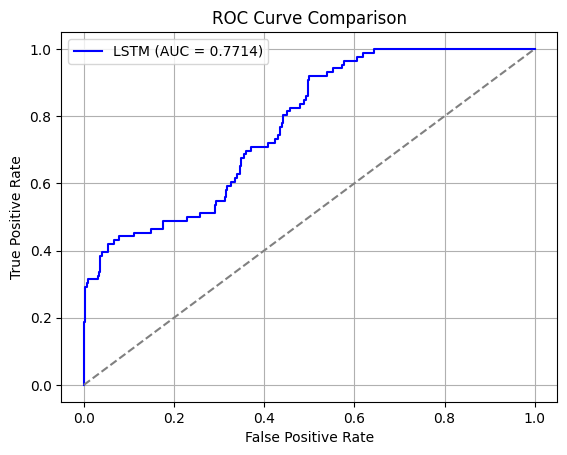

In [19]:
## ROC Curve
fpr_lstm, tpr_lstm, _ = roc_curve(y_test_seq, y_pred_lstm_prob)
roc_auc_lstm = auc(fpr_lstm, tpr_lstm)
plt.plot(fpr_lstm, tpr_lstm, color='blue', label=f'LSTM (AUC = {roc_auc_lstm:.4f})')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid()
plt.show()

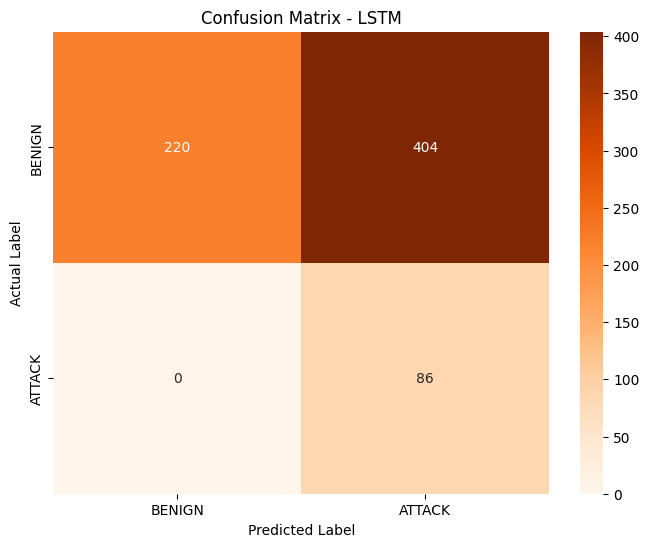

In [20]:
# Confusion Matrix
cm_lstm = confusion_matrix(y_test_seq, y_pred_lstm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Oranges', xticklabels=['BENIGN', 'ATTACK'], yticklabels=['BENIGN', 'ATTACK'])
plt.title('Confusion Matrix - LSTM')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()